# Initialization
- Importing libraries

- Importing images

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/AN2DL 2021/CHALLENGE 2

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/AN2DL 2021/CHALLENGE 2


In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Exploration Data Analysis

In [ ]:
dataset = pd.read_csv('Training.csv')
print(dataset.shape)
#dataset.info()
#dataset.head()

(68528, 7)


In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(18,14))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()

In [ ]:
def inspect_column(df, col_name):
    print('Column name: %s' % col_name)
    sub_df = df[col_name]
    mean = sub_df.mean()
    std = sub_df.std()

    print('Mean: %f' % mean)
    print('Standard Deviation: %f' % std)

    figs, axs = plt.subplots(2, 1, sharex=True, figsize=(14,5))

    diff = pd.Series()
    for i in range(len(sub_df)-1):
      diff.loc[i] = ( sub_df.iloc[i+1] - sub_df.iloc[i] )

    axs[0].plot(sub_df)
    axs[0].plot(diff)
    axs[0].plot( pd.Series(np.ones(len(sub_df))*mean) )

    #sub_df.iloc[:4000].plot(figsize=(20,4))
    diff = pd.Series()
    for i in range(len(sub_df)-1):
      diff.loc[i] = ( sub_df.iloc[i+1] - sub_df.iloc[i] )

    sub_df = pd.Series(sub_df - mean)/std

    axs[1].plot(sub_df)
    axs[1].plot(diff)
    axs[1].plot( pd.Series(np.zeros(len(sub_df))*mean) )

    plt.show()

In [ ]:
col_name = 'Sponginess'
# inspect_column(dataset[:300],col_name)
# Modify the print to better analyze data.
# Try deleting basic variations and focus on harder ones.

# Splitting Data

In [ ]:
'''
# Better to know how much i jumped or how much i will jump?
# In the second case:
# diff.loc[0]=0
# diff.loc[i+1] = ( sub_df.iloc[i+2] - sub_df.iloc[i+1] )
sub_df = dataset['Sponginess']

diff = pd.Series()
diff.loc[0]=0
for i in range(len(sub_df)-1):
  diff.loc[i+1] = ( sub_df.iloc[i+1] - sub_df.iloc[i] ) # .loc can enlarge the object

dataset.insert(len(dataset.columns), 'Jump', diff, allow_duplicates=True)

dataset.to_csv('Training_new.csv')
'''

"\n# Better to know how much i jumped or how much i will jump?\n# In the second case:\n# diff.loc[0]=0\n# diff.loc[i+1] = ( sub_df.iloc[i+2] - sub_df.iloc[i+1] )\nsub_df = dataset['Sponginess']\n\ndiff = pd.Series()\ndiff.loc[0]=0\nfor i in range(len(sub_df)-1):\n  diff.loc[i+1] = ( sub_df.iloc[i+1] - sub_df.iloc[i] ) # .loc can enlarge the object\n\ndataset.insert(len(dataset.columns), 'Jump', diff, allow_duplicates=True)\n\ndataset.to_csv('Training_new.csv')\n"

(62528, 7) (6000, 7)


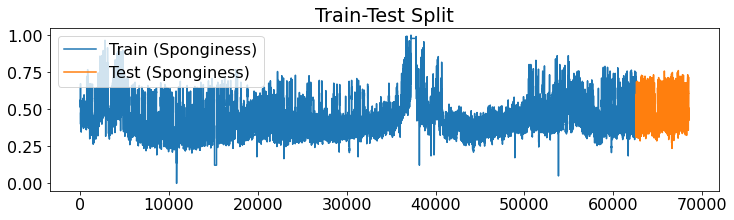

In [ ]:
test_size = 6000
X_train_raw = dataset.iloc[:-test_size]

# y_train_raw = y.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:] # Last 6000 data
# y_test_raw = y.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(12,3))
plt.plot(X_train_raw.Sponginess, label='Train (Sponginess)')
plt.plot(X_test_raw.Sponginess, label='Test (Sponginess)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [ ]:
# dataset.isnull().sum().sum() # Search for all the NaN in the dataframe.
# dataset['Sponginess'].isnull().values.any() # The column does not contain any NaN
# dataset.dropna() # Better to modify them to keep the same length of rows.

# inspect_dataframe(X_train_raw, X_train_raw.columns)

# df.replace(np.nan, 0)
# dataset[35000:40000]

# inspect_dataframe(X_train_raw, X_train_raw.columns)

# Functions definition

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [ ]:
def build_sequences(df, target_labels=['Sponginess'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])
        # Here it starts from the end and goes forward for telescope steps.

        # y is created here and is the x shifted in the future.

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [ ]:
def plot_history(history):
    best_epoch = np.argmin(history['val_loss'])
    plt.figure(figsize=(17,4))
    plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Mean Squared Error (Loss)')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Mean Absolute Error')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(18,3))
    plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

# Models

In [ ]:
def build_CONV_LSTM_model_2_layers(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.5)(convlstm)

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True))(input_layer)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(256, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(512, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.5)(convlstm)

    # We can skip dense layer, play with windows and shape to have only RNN from
    # the beginning to the end.
    # Avoid pooling operations without convolution, not brilliant.
    # Add layers from tensorflow repository.

    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model


In [ ]:
def build_E1D1_model(input_shape, output_shape, n_future):

    n_features=7;

    # Encoder
    encoder_inputs = tfkl.Input( shape = input_shape, name='Input' )
    encoder_l1 = tf.keras.layers.LSTM(256, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)

    encoder_states1 = encoder_outputs1[1:]

    # Decoder
    decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
    decoder_l1 = tf.keras.layers.LSTM(256, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

    # convlstm = tfkl.Dropout(.5)(convlstm)

    # Connect input and output through the Model class
    model = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

In [ ]:
def build_E2D2_model(input_shape, output_shape, n_future):

    n_features=7;

    # Encoder
    encoder_inputs = tf.keras.layers.Input(shape=input_shape)
    encoder_l1 = tf.keras.layers.LSTM(256,return_sequences = True, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)
    encoder_states1 = encoder_outputs1[1:]
    encoder_l2 = tf.keras.layers.LSTM(256, return_state=True)
    encoder_outputs2 = encoder_l2(encoder_outputs1[0])
    encoder_states2 = encoder_outputs2[1:]

    # Decoder
    decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
    decoder_l1 = tf.keras.layers.LSTM(256, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_l2 = tf.keras.layers.LSTM(256, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
    decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)

    # Connect input and output through the Model class
    model = tf.keras.models.Model(encoder_inputs,decoder_outputs2)

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

In [ ]:
def build_E3D3_model(input_shape, output_shape, n_future):

    n_features=7;

    # Encoder
    encoder_inputs = tf.keras.layers.Input(shape=input_shape)

    encoder_l1 = tf.keras.layers.LSTM(256,return_sequences = True, return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)
    encoder_states1 = encoder_outputs1[1:]

    encoder_l2 = tf.keras.layers.LSTM(256, return_sequences=True, return_state=True)
    encoder_outputs2 = encoder_l2(encoder_outputs1[0])
    encoder_states2 = encoder_outputs2[1:]

    encoder_l3 = tf.keras.layers.LSTM(256, return_state=True)
    encoder_outputs3 = encoder_l3(encoder_outputs2[0])
    encoder_states3 = encoder_outputs3[1:]

    # Decoder
    decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs3[0])

    decoder_l1 = tf.keras.layers.LSTM(256, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
    decoder_l2 = tf.keras.layers.LSTM(256, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
    decoder_l3 = tf.keras.layers.LSTM(256, return_sequences=True)(decoder_l2,initial_state = encoder_states3)

    decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l3)
    # Try to delete the dense layer

    # Connect input and output through the Model class
    model = tf.keras.models.Model(encoder_inputs,decoder_outputs2)

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

# Multivariate Forecasting (Direct)

In [ ]:
'''
future = dataset[-window:]  
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape
'''

target_labels = dataset.columns
window = 200 # Periodicity is 96
stride = 10
telescope = 96

X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

#inspect_multivariate(X_train, y_train, target_labels, telescope)

((6231, 200, 7), (6231, 96, 7), (571, 200, 7), (571, 96, 7))

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200
input_shape, output_shape

((200, 7), (96, 7))

In [ ]:
model = build_E2D2_model(input_shape, output_shape, telescope)
model.summary()
# tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.15,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
83/83 [==============================] - 28s 226ms/step - loss: 0.0316 - mae: 0.1205 - val_loss: 0.0154 - val_mae: 0.0885 - lr: 0.0010
Epoch 2/200
83/83 [==============================] - 17s 203ms/step - loss: 0.0093 - mae: 0.0662 - val_loss: 0.0141 - val_mae: 0.0765 - lr: 0.0010
Epoch 3/200
83/83 [==============================] - 17s 204ms/step - loss: 0.0086 - mae: 0.0636 - val_loss: 0.0129 - val_mae: 0.0721 - lr: 0.0010
Epoch 4/200
83/83 [==============================] - 17s 203ms/step - loss: 0.0084 - mae: 0.0627 - val_loss: 0.0130 - val_mae: 0.0733 - lr: 0.0010
Epoch 5/200
83/83 [==============================] - 17s 202ms/step - loss: 0.0084 - mae: 0.0625 - val_loss: 0.0129 - val_mae: 0.0727 - lr: 0.0010
Epoch 6/200
83/83 [==============================] - 17s 203ms/step - loss: 0.0081 - mae: 0.0619 - val_loss: 0.0127 - val_mae: 0.0730 - lr: 0.0010
Epoch 7/200
83/83 [==============================] - 17s 202ms/step - loss: 0.0081 - mae: 0.0616 - val_loss: 0.0124 - 

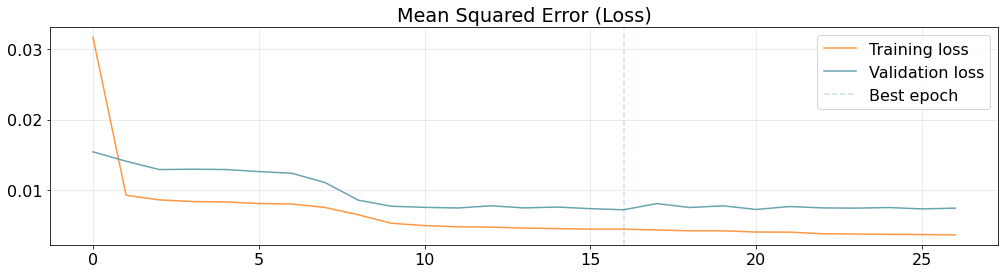

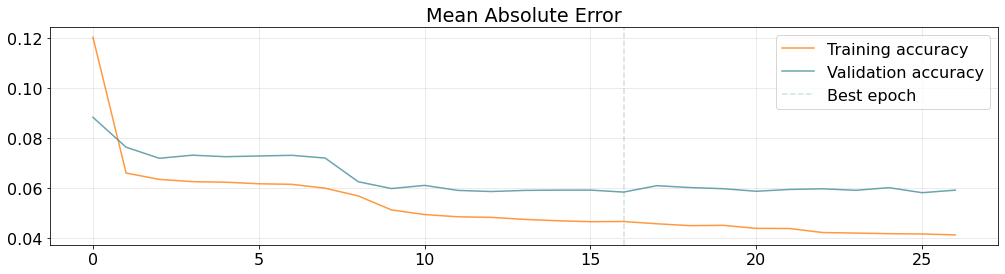

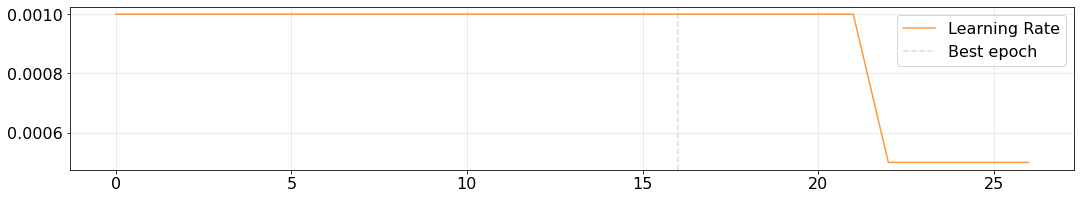

In [ ]:
plot_history(history)

In [ ]:
model.save('DirectForecasting_E2D2_one_fold')
# model = tfk.models.load_model('DirectForecasting_E2D2_2_test_added')

In [ ]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

(571, 96, 7)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.00989254>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.06643187>)

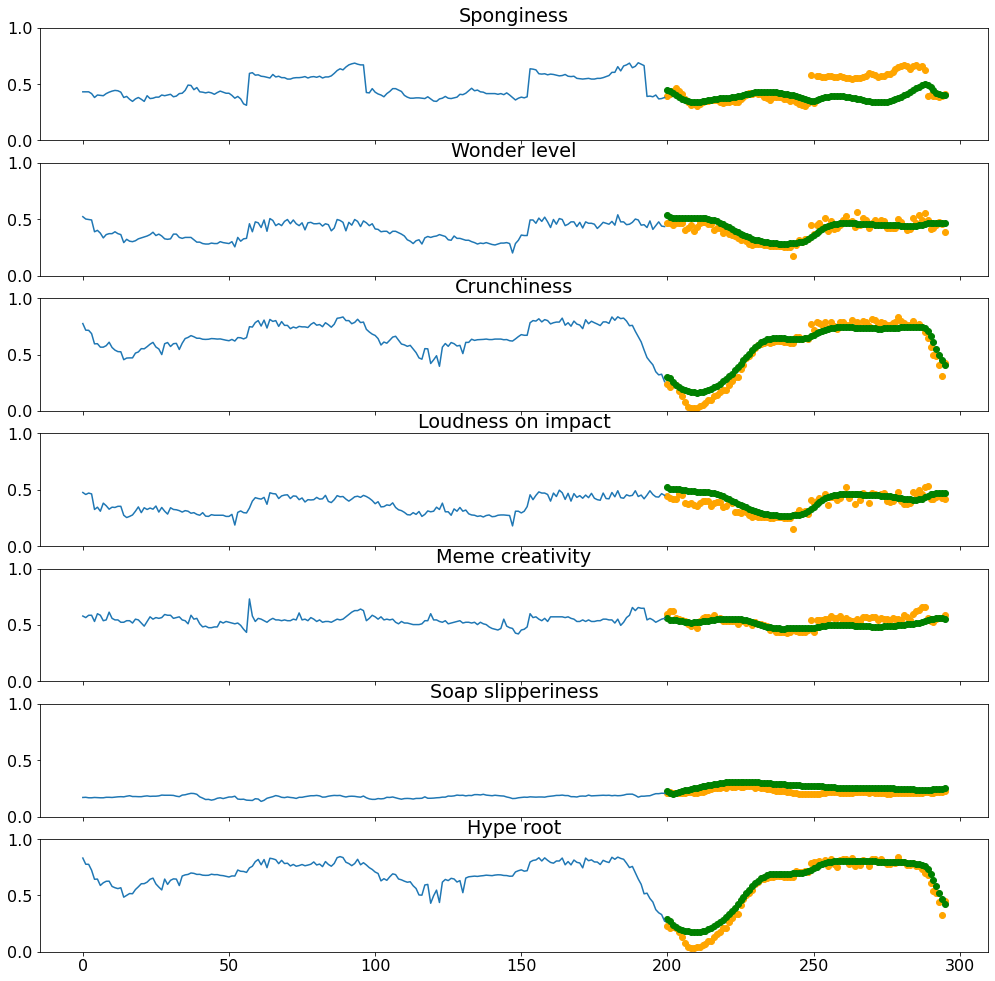

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope, 0)

In [ ]:
maes = []
for i in range(predictions.shape[1]):
    ft_maes = []
    for j in range(predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test[:,i,j]-predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

maes.shape

(96, 7)

In [ ]:
reg_telescope = 864

future = dataset[-window:] 
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)

n = int( reg_telescope/telescope )

reg_future = np.array([])
X_temp = future

for reg in range(n):
    pred_temp = model.predict(X_temp)
    if(len(reg_future)==0):
        reg_future = pred_temp
    else:
        reg_future = np.concatenate((reg_future,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,96:,:],pred_temp), axis=1)
    
reg_future.shape
#reg_future = reg_future * (X_max + X_min) - X_min  # denormalize


(1, 864, 7)

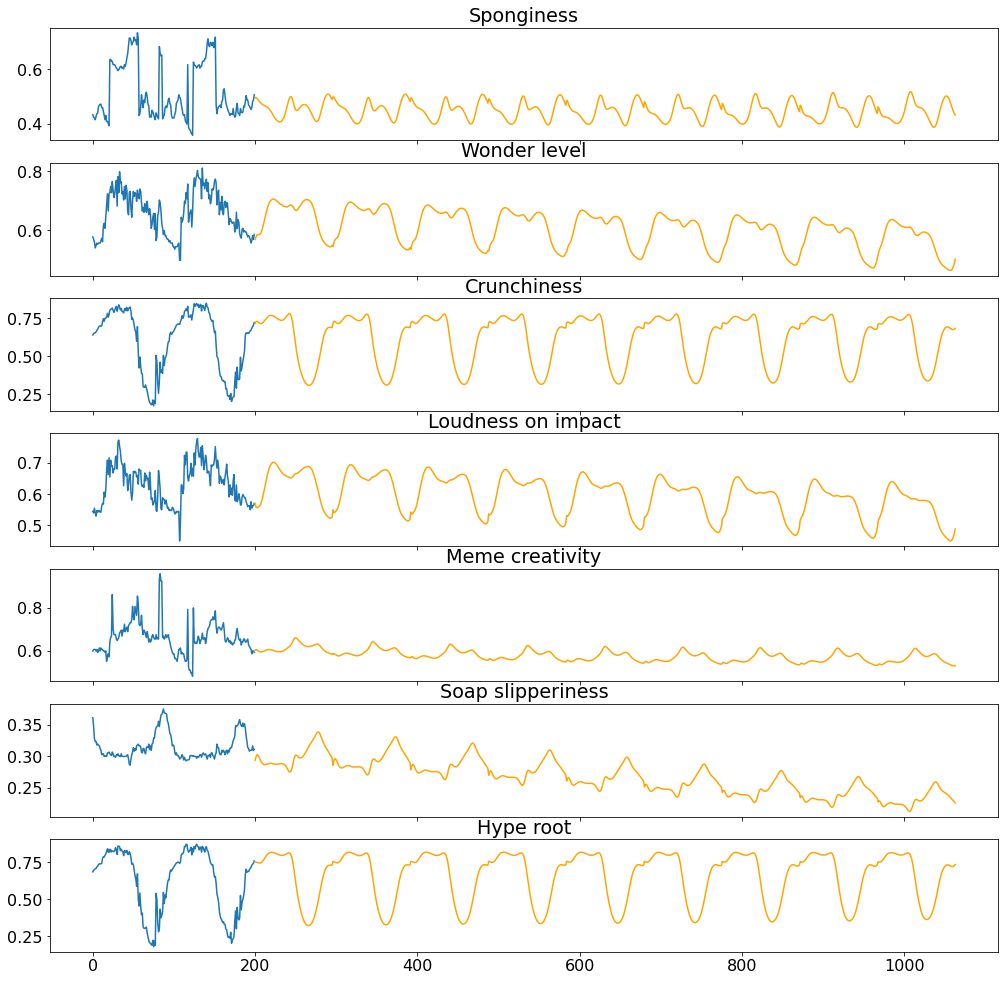

In [ ]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), reg_future[0,:,i], color='orange')
    """
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), 
        reg_future[0,:,i],#+maes[:,i], 
        reg_future[0,:,i],#-maes[:,i], 
        color='orange', alpha=.3)
    """
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()

# Cross Validation

In [ ]:
#dataset[0:len(dataset)]

In [ ]:
X_training = dataset#.iloc[:-test_size]

# Normalize both features and labels
X_min = X_training.min()
X_max = X_training.max()

X_training = (X_training-X_min)/(X_max-X_min)

target_labels = dataset.columns
window = 200 # Periodicity is 96
stride = 10

telescope = 96

This is an example image. Since we are using 4 folds the model is actually trained for 3 times.

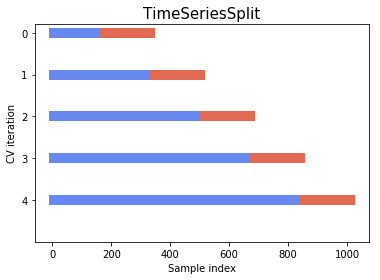

In [ ]:
#from sklearn.model_selection import KFold
#kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

num_folds = 4 #8 also
size = X_training.shape[0]
fold_size = size / num_folds # 68528 / 4 = 17132

histories = []
scores = []

model = build_E2D2_model(input_shape, output_shape, telescope)

for i in range(num_folds-1) :

  print("Starting training on fold num: {}".format(i+1))

  #X_fold = X_training.iloc[ 0 : ( (i+1)* fold_size) ]
  X_fold_train = X_training.iloc[ 0 : int( (i+1)*fold_size ) ]
  X_fold_val = X_training.iloc[ int( (i+1)* fold_size) : int( (i+2)* fold_size) ]

  X_train, y_train = build_sequences(X_fold_train, target_labels, window, stride, telescope)
  X_val, y_val = build_sequences(X_fold_val, target_labels, window, stride, telescope)

  input_shape = X_train.shape[1:]
  output_shape = y_train.shape[1:]
  batch_size = 64
  epochs = 50

  #model = build_E2D2_model(input_shape, output_shape, telescope)

  history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
  ).history

  score = model.evaluate(X_val, y_val) # Try divide a test set of size 864 ?
  scores.append(score[1])

  histories.append(history)

Starting training on fold num: 1
Epoch 1/50
27/27 [==============================] - 16s 329ms/step - loss: 0.0737 - mae: 0.1932 - val_loss: 0.0253 - val_mae: 0.1250 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 7s 261ms/step - loss: 0.0111 - mae: 0.0812 - val_loss: 0.0174 - val_mae: 0.1008 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 7s 262ms/step - loss: 0.0081 - mae: 0.0688 - val_loss: 0.0127 - val_mae: 0.0811 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 7s 261ms/step - loss: 0.0068 - mae: 0.0640 - val_loss: 0.0120 - val_mae: 0.0745 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 7s 261ms/step - loss: 0.0062 - mae: 0.0608 - val_loss: 0.0118 - val_mae: 0.0764 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 7s 260ms/step - loss: 0.0062 - mae: 0.0606 - val_loss: 0.0112 - val_mae: 0.0725 - lr: 0.0010
Epoch 7/50
27/27 [==============================] - 7s 263ms/step - loss: 0.0060 - mae: 0.0597 -

In [ ]:
model.save('Forecasting_E2D2_4_fold_training')

MSE
Mean: 0.0751; STD: 0.0065


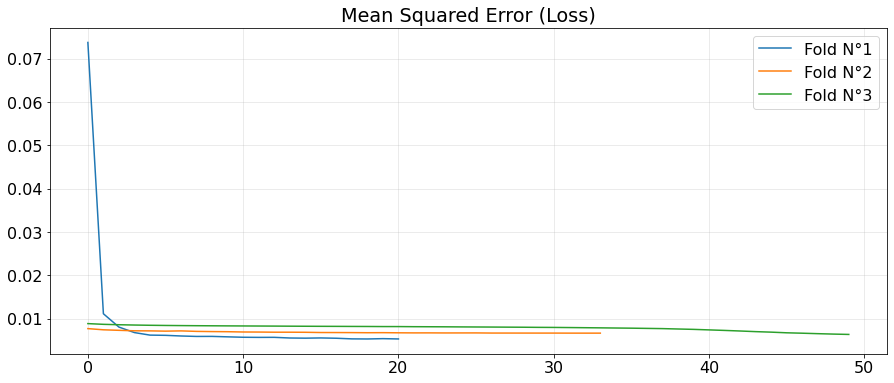

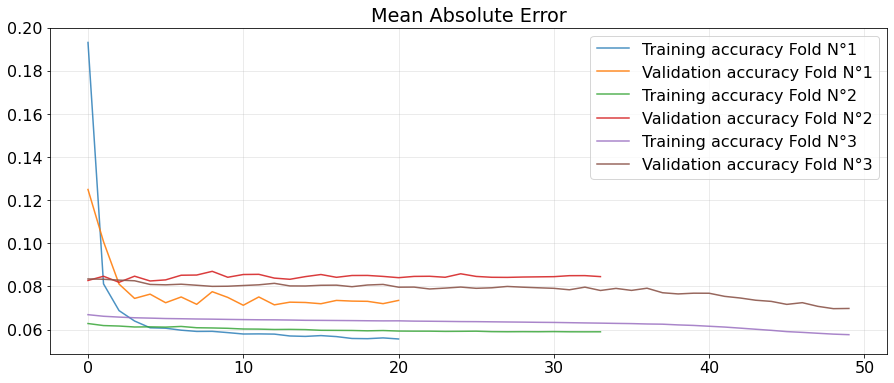

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

print("MSE")
print("Mean: {}; STD: {}".format(np.mean(scores).round(4), np.std(scores).round(4)))

plt.figure(figsize=(15,6))
for fold_idx in range(num_folds-1):
  plt.plot(histories[fold_idx]['loss'], color=colors[fold_idx], label='Fold N°{}'.format(fold_idx+1))
  #plt.ylim(0.011, 0.03)
  plt.title('Mean Squared Error (Loss)')
  plt.legend(loc='upper right')
  plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(15,6))
for fold_idx in range(num_folds-1):
    plt.plot(histories[fold_idx]['mae'], label='Training accuracy Fold N°{}'.format(fold_idx+1), alpha=.8)#, color='#ff7f0e')
    plt.plot(histories[fold_idx]['val_mae'], label='Validation accuracy Fold N°{}'.format(fold_idx+1), alpha=.9)#, color='#5a9aa5')
    #plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Mean Absolute Error')
    plt.legend(loc='upper right')
    plt.grid(alpha=.3)
plt.show()